<a href="https://colab.research.google.com/github/AbGhost-cyber/AbGhost-cyber/blob/main/Siamese_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
%matplotlib inline

In [3]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2023-06-23 10:25:04--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2023-06-23 10:25:05--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip’

at&t.zip            100%[===================>]   3.62M  --.-KB/s    in 0.01s   

2023-06-23 10:25:05 (306 MB/s) - ‘at&t.zip’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creating

In [4]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


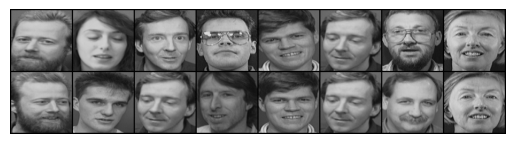

[0. 1. 0. 1. 0. 0. 1. 0.]


In [7]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [8]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers=2, dropout_prob=0.2):
        super(VGGBlock, self).__init__()

        layers = []
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout_prob))
            in_channels = out_channels

            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

In [9]:
class SiameseNet2(nn.Module):
    def __init__(self):
        super(SiameseNet2, self).__init__()

        self.cnn1 = nn.Sequential(
            VGGBlock(1, 96),
            VGGBlock(96, 256),
            VGGBlock(256, 384),
            # VGGBlock(256, 512)
        )

        self.fc1 = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=384, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=2)

        )

    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similarity
        output = self.cnn1(x)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # we pass in both images and obtain both vectors
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2


In [10]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidean distance an contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

Epoch number 0
 Current loss 1.670964002609253

Epoch number 1
 Current loss 2.0972213745117188

Epoch number 2
 Current loss 1.563095211982727

Epoch number 3
 Current loss 2.1434597969055176

Epoch number 4
 Current loss 1.4875750541687012

Epoch number 5
 Current loss 1.3996145725250244

Epoch number 6
 Current loss 1.518200397491455

Epoch number 7
 Current loss 1.2682090997695923

Epoch number 8
 Current loss 1.2506709098815918

Epoch number 9
 Current loss 1.034177541732788

Epoch number 10
 Current loss 1.1583020687103271

Epoch number 11
 Current loss 1.0203627347946167

Epoch number 12
 Current loss 1.176112174987793

Epoch number 13
 Current loss 1.1445411443710327

Epoch number 14
 Current loss 1.0319019556045532

Epoch number 15
 Current loss 0.6186608076095581

Epoch number 16
 Current loss 0.98139488697052

Epoch number 17
 Current loss 0.6431137919425964

Epoch number 18
 Current loss 1.0791224241256714

Epoch number 19
 Current loss 0.909696102142334

Epoch number 20
 C

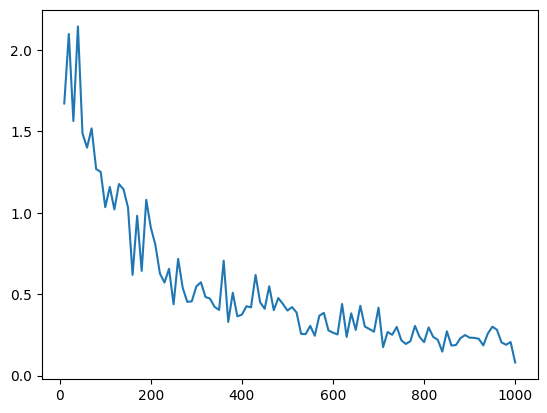

In [15]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8,batch_size=64)
net = SiameseNet2().to(device)
criterion = ContrastiveLoss()
lr = 5e-3
optimizer = optim.Adam(net.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration_number = 0

num_epochs = 100

net.train()
# Iterate through the epochs
for epoch in range(num_epochs):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

      # Send the images and labels to CUDA
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0:
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)